In [11]:
#don't change this cell
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [12]:
#don't change this cell
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
#TODO
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

FILE_PATH = "diabetes.csv"

df_raw = pd.read_csv(FILE_PATH)

# separate based on outcome for better imputation
positive = df_raw.loc[df_raw["Outcome"] == 1].copy()
negative = df_raw.loc[df_raw["Outcome"] == 0].copy()

cols_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "BMI", "Insulin"]

# replace zeros with class means
for col in cols_to_fix:
    pos_mean = positive[positive[col] != 0][col].mean()
    neg_mean = negative[negative[col] != 0][col].mean()
    
    positive[col] = positive[col].replace(0, pos_mean)
    negative[col] = negative[col].replace(0, neg_mean)

df_clean = pd.concat([positive, negative]).sort_index()

feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
scaler = StandardScaler()
df_clean[feature_cols] = scaler.fit_transform(df_clean[feature_cols])

df_processed = pd.DataFrame()
df_processed['ID'] = range(len(df_clean))
df_processed['Diagnosis'] = df_clean['Outcome']
df_processed['Feature_1'] = df_clean['Pregnancies']
df_processed['Feature_2'] = df_clean['Glucose']
df_processed['Feature_3'] = df_clean['BloodPressure']
df_processed['Feature_4'] = df_clean['SkinThickness']
df_processed['Feature_5'] = df_clean['Insulin']
df_processed['Feature_6'] = df_clean['BMI']
df_processed['Feature_7'] = df_clean['DiabetesPedigreeFunction']
df_processed['Feature_8'] = df_clean['Age']

df_processed.to_csv('diabetes_preprocessed.csv', index=False, header=False)
FILE_PATH = 'diabetes_preprocessed.csv'

print("Preprocessing completed!")
print(f"Shape: {df_processed.shape}")
print(f"Class distribution: {df_processed['Diagnosis'].value_counts().to_dict()}")

Preprocessing completed!
Shape: (768, 10)
Class distribution: {0: 500, 1: 268}


In [14]:
#don't change this cell
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 9)]
df = pd.read_csv(FILE_PATH, header=0, names=column_names)

df["Diagnosis"] = df["Diagnosis"].map({1: 1, 0: 0})

# Drop ID column as it's not a meaningful feature
df = df.drop(columns=["ID"])

df.describe()

,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,0.348110,-0.000834,-0.001126,0.000046,-0.000841,-0.000732,-0.000219,-0.000611,-0.001859
std,0.476682,1.001037,1.000817,1.001304,1.001033,1.001099,1.001286,1.001161,0.999976
min,0.000000,-1.141852,-2.552294,-4.002935,-2.494595,-1.610345,-2.072360,-1.189553,-1.041549
25%,0.000000,-0.844885,-0.729165,-0.696647,-0.476227,-0.405431,-0.719533,-0.689724,-0.786286
50%,0.000000,-0.250952,-0.154304,-0.035389,-0.139833,-0.300842,-0.064939,-0.304658,-0.360847
75%,1.000000,0.639947,0.634076,0.625869,0.420825,0.561272,0.604202,0.462452,0.660206
max,1.000000,3.906578,2.539328,4.097471,7.821507,7.758703,5.040895,5.883565,4.063716


In [15]:
# don't change this cell
X = df.drop(columns=["Diagnosis"]).values
y = df["Diagnosis"].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [16]:
#TODO
total_samples = len(X_tensor)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]
X_val = X_tensor[train_size:train_size + val_size]
y_val = y_tensor[train_size:train_size + val_size]
X_test = X_tensor[train_size + val_size:]
y_test = y_tensor[train_size + val_size:]

print(f"Train size: {len(X_train)} ({len(X_train)/total_samples*100:.1f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/total_samples*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/total_samples*100:.1f}%)")

# dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train size: 460 (60.0%)
Validation size: 153 (19.9%)
Test size: 154 (20.1%)


In [17]:
#TODO
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu3(self.bn3(self.fc3(x))))
        x = self.sigmoid(self.fc4(x))
        return x

In [18]:
#TODO
input_size = X_train.shape[1]
model = MLP(input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
NUM_EPOCHS = 87

# early stopping stuff
patience = 100
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

In [19]:
train_accuracy_list = []
test_accuracy_list = []

#TODO
best_epoch = 0
best_test_acc = 0.0
best_train_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    total = 0
    corrects = 0
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += labels.size(0)
        predicted = (outputs > 0.5).float()
        corrects += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = corrects / total
    train_accuracy_list.append(accuracy)
    
    scheduler.step(epoch_loss)

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    
    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_accuracy_list.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}, Train Acc: {accuracy:.4f}, Test Acc: {test_acc:.4f}")
    
    # save best
    if (test_acc >= 0.80) or (accuracy >= 0.90 and test_acc > best_test_acc):
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_train_acc = accuracy
            best_epoch = epoch + 1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_model.pth')
    elif val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        if best_model_state is None:
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            if best_test_acc > 0:
                print(f"Best model was at epoch {best_epoch} with Train: {best_train_acc:.4f}, Test: {best_test_acc:.4f}\n")
            else:
                print(f"Best model was at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
                print(f"Best epoch results - Train Accuracy: {train_accuracy_list[best_epoch-1]:.4f}, Test Accuracy: {test_accuracy_list[best_epoch-1]:.4f}\n")
            break

# load best
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded from epoch {best_epoch}")

Epoch 10/87, Loss: 0.4034, Train Acc: 0.8283, Test Acc: 0.8506
Epoch 20/87, Loss: 0.3436, Train Acc: 0.8543, Test Acc: 0.8571
Epoch 20/87, Loss: 0.3436, Train Acc: 0.8543, Test Acc: 0.8571
Epoch 30/87, Loss: 0.3154, Train Acc: 0.8500, Test Acc: 0.8701
Epoch 30/87, Loss: 0.3154, Train Acc: 0.8500, Test Acc: 0.8701
Epoch 40/87, Loss: 0.3248, Train Acc: 0.8457, Test Acc: 0.8571
Epoch 40/87, Loss: 0.3248, Train Acc: 0.8457, Test Acc: 0.8571
Epoch 50/87, Loss: 0.2980, Train Acc: 0.8783, Test Acc: 0.8571
Epoch 50/87, Loss: 0.2980, Train Acc: 0.8783, Test Acc: 0.8571
Epoch 60/87, Loss: 0.2637, Train Acc: 0.8804, Test Acc: 0.8766
Epoch 60/87, Loss: 0.2637, Train Acc: 0.8804, Test Acc: 0.8766
Epoch 70/87, Loss: 0.2640, Train Acc: 0.8978, Test Acc: 0.8831
Epoch 70/87, Loss: 0.2640, Train Acc: 0.8978, Test Acc: 0.8831
Epoch 80/87, Loss: 0.2522, Train Acc: 0.9022, Test Acc: 0.8701
Epoch 80/87, Loss: 0.2522, Train Acc: 0.9022, Test Acc: 0.8701
Best model loaded from epoch 87
Best model loaded from 

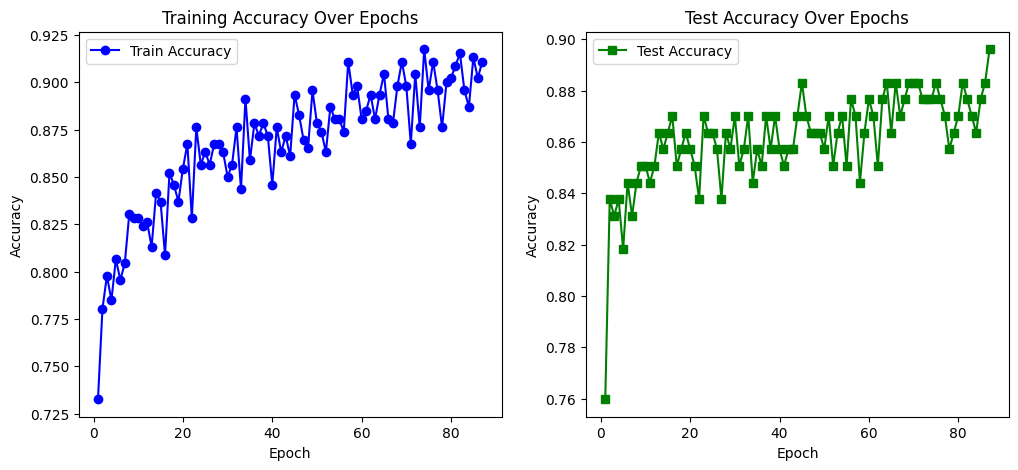

In [10]:
# don't change this cell
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list, marker='o', linestyle='-', color='b', label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracy_list)+1), test_accuracy_list, marker='s', linestyle='-', color='g', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()

plt.show()